# Pole-placement ontwerp (state-space benadering)
1. Control-system design (§4.2)
2. Regelen met state-feedback (§4.3)
3. Deadbeat Control (§4.3)

In [1]:
import numpy as np
from numpy.linalg import eig,inv
import matplotlib.pyplot as plt
from mbrtc import *

# vgl. Example 4.1
h = 0.1
# discrete time system
A = np.array([[1.,h],[0.,1.]])
B = np.array([[h**2/2],[h]])
C = np.array([[1.0,0.0]])
D = np.array([[0.]])

print(f"Polen van niet geregelde discrete tijd systeem: {eig(A)[0]}")


Polen van niet geregelde discrete tijd systeem: [1. 1.]


In [2]:
w_desired           = 2.  # desired resonance frequency of continuous-time poles
zeta_desired        = 1.  # desired damping ratio of continuous-time poles
char_poly_cont      = np.array([1., 2*zeta_desired*w_desired, w_desired**2])
poles_desired_cont  = np.roots(char_poly_cont)
poles_desired_discr = np.exp(poles_desired_cont*h)
char_poly_discr     = np.poly(poles_desired_discr)

print(f"Gewenste polen in continue tijd: {poles_desired_cont}")
print(f"Gewenste polen in discrete tijd: {poles_desired_discr}")
print(f"Gewenste karakteristieke polynoom (discrete tijd): {char_poly_discr}")


Gewenste polen in continue tijd: [-2. -2.]
Gewenste polen in discrete tijd: [0.81873075 0.81873075]
Gewenste karakteristieke polynoom (discrete tijd): [ 1.         -1.63746151  0.67032005]


In [3]:

p1 = char_poly_discr[1]
p2 = char_poly_discr[2]

# See book example 4.1
l1 = (1+p1+p2)/h**2
l2 = (3+p1-p2)/(2*h)

L = np.array([[l1,l2]])

A_closed_loop = A - B @ L

print(f"Polen van geregelde discrete tijd systeem: {eig(A_closed_loop)[0]}")



Polen van geregelde discrete tijd systeem: [0.81873075+4.7781401e-09j 0.81873075-4.7781401e-09j]


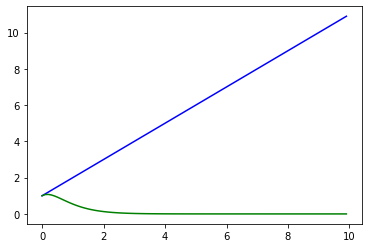

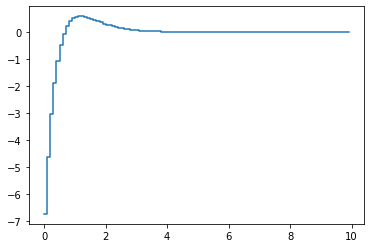

In [4]:
NS = 100
td = np.arange(NS)*h
u = np.zeros((NS)); # no input
x0 = np.ones((2))   # initial state

y_open_loop = sim(A,B,C,D,u,x0)
y_closed_loop = sim(A_closed_loop,B,C,D,u,x0)

u_closed_loop = sim(A_closed_loop,B,-L,np.zeros((1,1)),u,x0)


plt.plot(td,y_open_loop,'b')
plt.plot(td,y_closed_loop,'g')

plt.figure()
plt.step(td,u_closed_loop,where='post')

In [5]:
print(f"L={L}")
L_computed_with_place = place(A,B,poles_desired_discr)
print(f"L_computed_with_place",L_computed_with_place)

L=[[3.28585399 3.46109224]]
L_computed_with_place [[3.28585399 3.46109224]]


In [6]:
help(place)

Help on function place in module mbrtc:

place(A, B, pole_vec)
    Calculates the state-feedback matrix L such that the poles are at
    the specified locations in the vector pole_vec.



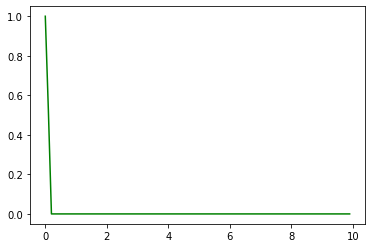

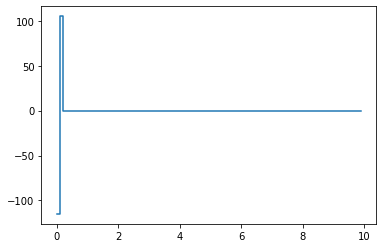

In [7]:
# deadbeat control:
poles_desired = np.array([0.,0.])
L_db = place(A,B,poles_desired)

NS = 100
td = np.arange(NS)*h
u = np.zeros((NS)); # no input
x0 = np.ones((2)) # initial state

y_open_loop = sim(A,B,C,D,u,x0)
y_closed_loop = sim(A - B @ L_db,B,C,D,u,x0)

u_closed_loop = sim(A - B @ L_db,B,-L_db,D,u,x0)

#plt.plot(td,y_open_loop,'b')
plt.plot(td,y_closed_loop,'g')

plt.figure()
plt.step(td,u_closed_loop,where='post')


In [8]:
# DC_gain is gain from u_desired to y
DC_gain = dc_gain(A_closed_loop,B,C,D); #C @ inv(np.eye(2)-A+B@L) @ B
# u[k] = -L x[k] + alpha * u_desired[k]
# choose alpha = 1/DC_gain such that DC gain from u_desired to y is one
alpha = 1/DC_gain[0,0]
DC_gain

array([[0.30433489]])

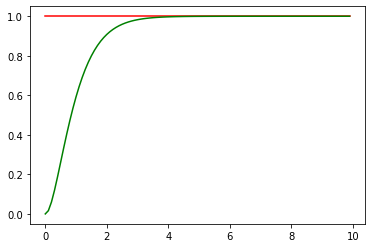

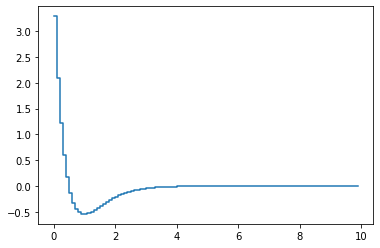

In [9]:
# tracking step signal:
NS = 100
td = np.arange(NS)*h
u_desired = np.ones((NS)); # step input
x0 = np.zeros((2)) # zero initial state

y_open_loop = sim(A,B,C,D,u_desired,x0)
# u[k] = -L x[k] + alpha * u_desired[k]
y_closed_loop = sim(A_closed_loop,B*alpha,C,D,u_desired,x0)

u_closed_loop = sim(A_closed_loop,B*alpha,-L,np.array([[alpha]]),u_desired,x0)

#plt.plot(td,u_desired,'r')
#plt.plot(td,y_open_loop,'b')

plt.figure()
plt.plot(td,u_desired,'r')
plt.plot(td,y_closed_loop,'g')

plt.figure()
plt.step(td,u_closed_loop,where='post')